In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor   
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [7]:
file_path = "C:\\Users\\Prat_\\Downloads\\combined_file10.nc"
data = xr.open_dataset(file_path)
data

<xarray.Dataset>
Dimensions:   (index: 177, file: 6)
Coordinates:
  * index     (index) int32 0 1 2 3 4 5 6 7 ... 169 170 171 172 173 174 175 176
Dimensions without coordinates: file
Data variables:
    Dates     (file, index) datetime64[ns] ...
    LST       (file, index) float64 ...
    SAVI      (file, index) float64 ...
    BI        (file, index) float64 ...
    SMAP      (file, index) float64 ...
    Rainfall  (file, index) float64 ...
    MNDWI     (file, index) float64 ...

In [4]:
data=data.drop_vars("Dates")
data

ValueError: One or more of the specified variables cannot be found in this dataset

In [5]:
data.isnull().sum()

<xarray.Dataset>
Dimensions:   ()
Data variables:
    LST       int32 160
    SAVI      int32 160
    BI        int32 160
    SMAP      int32 160
    Rainfall  int32 160
    MNDWI     int32 160

In [21]:
data=data.fillna(0)

In [22]:
data.isnull().sum()

<xarray.Dataset>
Dimensions:   ()
Data variables:
    NDVI      int32 0
    SAVI      int32 0
    MNDWI     int32 0
    SMAP      int32 0
    Rainfall  int32 0
    RVI       int32 0
    BI        int32 0
    TS        int32 0
    LST       int32 0

In [23]:
variables_to_drop = ["SMAP"]
x = data.drop_vars(variables_to_drop)
y = data["SMAP"]
x_shape = x.to_array().shape
y_shape = y.shape
print('shape of x:', x_shape)
print('shape of y:', y_shape)

shape of x: (8, 6, 177)
shape of y: (6, 177)


In [24]:
from sklearn.model_selection import train_test_split
x_df = x.to_dataframe().reset_index(drop=True)
y_df = y.to_dataframe().reset_index(drop=True)
X_train, X_test, Y_train, Y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=51, shuffle=False)
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (743, 8)
Shape of Y_train: (743, 1)
Shape of X_test: (319, 8)
Shape of Y_test: (319, 1)


In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1500, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,4,6,8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3, 4,5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [26]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'bootstrap': [True, False]}


In [27]:
rf_Model = RandomForestRegressor()
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator=rf_Model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
print(Y_train.isnull().sum())
rf_Grid.fit(X_train, Y_train)
Y_train = Y_train.fillna(Y_train.mean())

SMAP    0
dtype: int64
Fitting 3 folds for each of 7200 candidates, totalling 21600 fits


C:\Users\Prat_\OneDrive\Desktop\anaconda\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [32]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1100}

In [33]:
#Check Accuracy
print (f'Train Accuracy - : {rf_Grid.score(X_train,Y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,Y_test):.3f}')

Train Accuracy - : 0.969
Test Accuracy - : 0.667


In [34]:
#Create a Random Forest regressor object from Random Forest Regressor class
RFReg = RandomForestRegressor(n_estimators =600 , max_depth=10, max_features="sqrt", min_samples_leaf=2, 
                              min_samples_split=4, bootstrap=False, random_state = 0)
  
#Fit the random forest regressor with training data represented by X_train and y_train
RFReg.fit(X_train, Y_train)

C:\Users\Prat_\AppData\Local\Temp\ipykernel_25616\55209483.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFReg.fit(X_train, Y_train)


RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=4, n_estimators=600,
                      random_state=0)

In [35]:
#Predicted Height from test dataset w.r.t Random Forest Regression
y_predict_test = RFReg.predict((X_test))
y_predict_train = RFReg.predict((X_train))

In [36]:
testdata = Y_test.to_numpy()
df= pd.DataFrame(testdata,columns=['Test Data'])
df['Pred-test']= pd.DataFrame(y_predict_test,columns=['Pred-test'])

In [37]:
df['Pred-test'] = df['Pred-test'].mask(df['Pred-test'] <0, 0)
df['date'] = pd.date_range(start='15/12/2018', periods=len(df), freq='D').strftime('%Y-%m-%d')
df = df[['date', 'Test Data','Pred-test']]
df


C:\Users\Prat_\AppData\Local\Temp\ipykernel_25616\4048294979.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.date_range(start='15/12/2018', periods=len(df), freq='D').strftime('%Y-%m-%d')


,date,Test Data,Pred-test
0,2018-12-15,21.994,15.110177
1,2018-12-16,23.599,22.976951
2,2018-12-17,23.758,13.010645
3,2018-12-18,23.680,22.199217
4,2018-12-19,25.063,13.471010
...,...,...,...
314,2019-10-25,10.721,13.042142
315,2019-10-26,11.581,12.457867
316,2019-10-27,14.358,11.761342
317,2019-10-28,17.544,13.308216


In [38]:
traindata = Y_train.to_numpy()
df2= pd.DataFrame(traindata,columns=['Train Data'])
df2['Pred-train']= pd.DataFrame(y_predict_train,columns=['Pred-train'])
df2['date'] = pd.date_range(start='15/12/2018', periods=len(df2), freq='D').strftime('%Y-%m-%d')
df2 = df2[['date', 'Train Data','Pred-train']]
df2

C:\Users\Prat_\AppData\Local\Temp\ipykernel_25616\3437852356.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2['date'] = pd.date_range(start='15/12/2018', periods=len(df2), freq='D').strftime('%Y-%m-%d')


,date,Train Data,Pred-train
0,2018-12-15,20.097,19.241772
1,2018-12-16,18.730,18.820090
2,2018-12-17,24.055,21.369841
3,2018-12-18,23.259,20.824859
4,2018-12-19,20.249,20.226359
...,...,...,...
738,2020-12-22,16.159,12.563569
739,2020-12-23,15.228,11.823533
740,2020-12-24,22.049,21.733547
741,2020-12-25,24.230,21.859975


In [39]:
df2['Pred-train'] = df2['Pred-train'].mask(df2['Pred-train'] <0, 0)
df2

,date,Train Data,Pred-train
0,2018-12-15,20.097,19.241772
1,2018-12-16,18.730,18.820090
2,2018-12-17,24.055,21.369841
3,2018-12-18,23.259,20.824859
4,2018-12-19,20.249,20.226359
...,...,...,...
738,2020-12-22,16.159,12.563569
739,2020-12-23,15.228,11.823533
740,2020-12-24,22.049,21.733547
741,2020-12-25,24.230,21.859975


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
r_square = metrics.r2_score(Y_test, y_predict_test)

mse=mean_squared_error(Y_test, y_predict_test)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y_test, y_predict_test)
corr=df.corr(method='pearson')

print('TEST DATA')
print('Mean Square Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Error: {:.4f}'.format(mae))
print('R-Square: {:.4f}'.format(r_square))
print('Pearson Correlation: {:.4f}'.format(corr.iloc[1][0]))

TEST DATA
Mean Square Error: 20.1176
Root Mean Square Error: 4.4853
Mean Absolute Error: 3.4723
R-Square: 0.6479
Pearson Correlation: 0.8111


C:\Users\Prat_\AppData\Local\Temp\ipykernel_25616\879791031.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=df.corr(method='pearson')


In [41]:
r_square2 = metrics.r2_score(Y_train, y_predict_train)
mse2=mean_squared_error(Y_train, y_predict_train)
rmse2=np.sqrt(mse)
mae2=mean_absolute_error(Y_train, y_predict_train)
corr2=df2.corr(method='pearson')

print('TRAIN DATA')
print('Mean Square Error: {:.4f}'.format(mse2))
print('Root Mean Square Error: {:.4f}'.format(rmse2))
print('Mean Absolute Error: {:.4f}'.format(mae2))
print('R-Square: {:.4f}'.format(r_square2))
print('Pearson Correlation: {:.4f}'.format(corr2.iloc[1][0]))

TRAIN DATA
Mean Square Error: 4.3105
Root Mean Square Error: 4.4853
Mean Absolute Error: 1.3910
R-Square: 0.9477
Pearson Correlation: 0.9765


C:\Users\Prat_\AppData\Local\Temp\ipykernel_25616\3610374428.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr2=df2.corr(method='pearson')


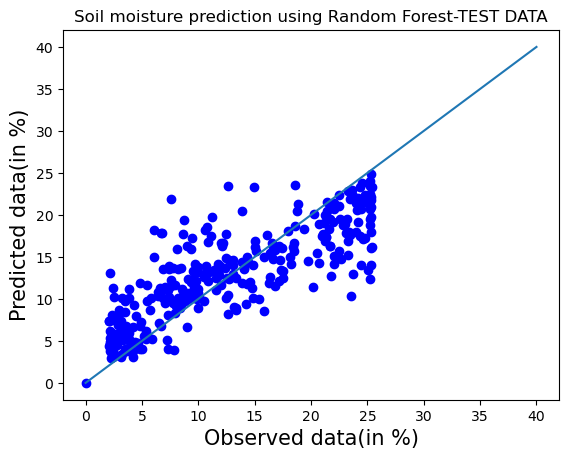

In [43]:
import matplotlib.pyplot as plt
plt.scatter(Y_test,y_predict_test,color='blue')
plt.xlabel('Observed data(in %)', fontsize=15)
plt.ylabel('Predicted data(in %)', fontsize=15)
plt.title('Soil moisture prediction using Random Forest-TEST DATA')
#plt.hold(True)
plt.plot([0,40],[0,40])

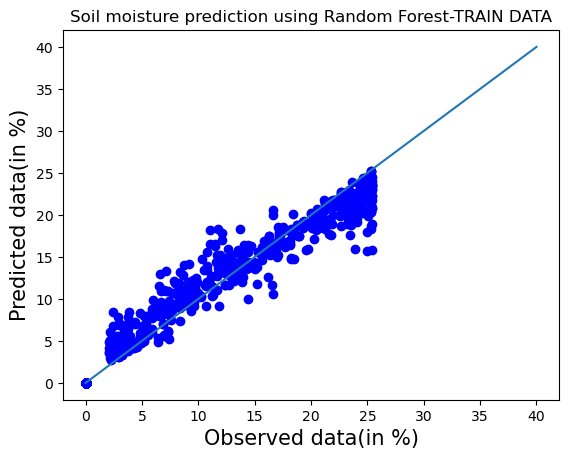

In [45]:
plt.scatter(Y_train,y_predict_train,color='blue')
plt.xlabel('Observed data(in %)', fontsize=15)
plt.ylabel('Predicted data(in %)', fontsize=15)
plt.title('Soil moisture prediction using Random Forest-TRAIN DATA')
#plt.hold(True)
plt.plot([0,40],[0,40])

In [27]:
df.to_excel("C:\\Users\\Prat_\\Downloads\\soil_moisture\\TEST_new.xlsx")

In [28]:
df2.to_excel("C:\\Users\\Prat_\\Downloads\\soil_moisture\\Train_new.xlsx")